Привет! 

Имеем три фрейма с результатами А В теста и гипотезами :  
df_hypoth  - фрейм содержащий в себе данные о гипотезах подлежащих к приоретизации и следующими столбцами:
Hypothesis — краткое описание гипотезы;  
Reach — охват пользователей по 10-балльной шкале;  
Impact — влияние на пользователей по 10-балльной шкале;  
Confidence — уверенность в гипотезе по 10-балльной шкале;  
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.  
  
  
df_orders - фрейм с данными по заказам :  
transactionId — идентификатор заказа;  
visitorId — идентификатор пользователя, совершившего заказ;  
date — дата, когда был совершён заказ;  
revenue — выручка заказа;  
group — группа A/B-теста, в которую попал заказ.  
  
df_visitors - фрейм с количеством посетителей и слкедующими столбцами:  
date — дата;  
group — группа A/B-теста;  
visitors — количество пользователей в указанную дату в указанной группе A/B-теста  
  
Необходимо приоритизировать гипотезы, и проанализировать результаты A/B-теста.  
Для приоретизации гипотез :   
Применим фреймворки ICE и RICE для приоритизации гипотез  и сравним полученные результаты  
Для анализа результатов А/В теста :  
1) Построим графики кумулятивной выручки и среднего чека по группам.  
2) Построим график относительного изменения кумулятивного среднего чека группы B к группе A.    
3) Построим график кумулятивной конверсии по группам.   
4) Построим график относительного изменения кумулятивной конверсии группы B к группе A.   
5) Построим точечный график количества заказов по пользователям.   
6) Для выбора аномальной границы пользователей посчитаем 95-й и 99-й перцентили количества заказов на пользователя.   
7) Построим точечный график стоимостей заказов.   
8) Для выбора границы аномальных заказов посчитаем 95-й и 99-й перцентили стоимости заказов.   
9) Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным.  
10) Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «очищенным» данным.  
11) По результатам анализа будет принято решение в отношении проведенного А/В теста.  


In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df_hypoth = pd.read_csv('/datasets/hypothesis.csv')
df_orders = pd.read_csv('/datasets/orders.csv')
df_visitors = pd.read_csv('/datasets/visitors.csv')

Проверим данные во фреймах 

In [3]:
df_hypoth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [5]:
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Все колонки имеющие в себе дату имеют не верный формат

In [6]:
df_orders['date'] = pd.to_datetime(df_orders['date'])
df_visitors['date'] = pd.to_datetime(df_visitors['date'])

In [7]:
df_hypoth.head(5)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [8]:
df_orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [9]:
df_visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## Часть 1 Приоритизация гипотез

Применим фреймворк ICE

In [10]:
df_hypoth['ICE'] = df_hypoth['Impact'] * df_hypoth['Confidence'] / df_hypoth['Efforts']
df_hypoth['ICE'] = round(df_hypoth['ICE'], 1)
print(df_hypoth[['Hypothesis', 'ICE']].sort_values(by = 'ICE', ascending = False))

                                          Hypothesis   ICE
8  Запустить акцию, дающую скидку на товар в день...  16.2
0  Добавить два новых канала привлечения трафика,...  13.3
7  Добавить форму подписки на все основные страни...  11.2
6  Показать на главной странице баннеры с актуаль...   8.0
2  Добавить блоки рекомендаций товаров на сайт ин...   7.0
1  Запустить собственную службу доставки, что сок...   2.0
5  Добавить страницу отзывов клиентов о магазине,...   1.3
3  Изменить структура категорий, что увеличит кон...   1.1
4  Изменить цвет фона главной страницы, чтобы уве...   1.0


In [11]:
df_hypoth['RICE'] = df_hypoth['Reach'] * df_hypoth['Impact'] * df_hypoth['Confidence'] / df_hypoth['Efforts']
df_hypoth['RICE'] = round(df_hypoth['RICE'], 1)
print(df_hypoth[['Hypothesis', 'RICE']].sort_values(by = 'RICE', ascending = False))

                                          Hypothesis   RICE
7  Добавить форму подписки на все основные страни...  112.0
2  Добавить блоки рекомендаций товаров на сайт ин...   56.0
0  Добавить два новых канала привлечения трафика,...   40.0
6  Показать на главной странице баннеры с актуаль...   40.0
8  Запустить акцию, дающую скидку на товар в день...   16.2
3  Изменить структура категорий, что увеличит кон...    9.0
1  Запустить собственную службу доставки, что сок...    4.0
5  Добавить страницу отзывов клиентов о магазине,...    4.0
4  Изменить цвет фона главной страницы, чтобы уве...    3.0


При применении фреймворка RICE вместо  ICE, гипотеза 8 с 1 места по преспективности упала до 5 , а 7 с 3 до 1 . Обяснение в показателе reach - гипотеза под номером 7 затронит много больше пользователей чем гипотеза под № 8



## Часть 2 Анализ А/В теста

График кумулятивной выручки по группам

Собираем кумулятивные данные

In [12]:
datesGroups = df_orders[['date','group']].drop_duplicates()

In [13]:
ordersAggregated = datesGroups.apply(lambda x: df_orders[np.logical_and(df_orders['date'] <= x['date'], df_orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [14]:
visitorsAggregated = datesGroups.apply(lambda x: df_visitors[np.logical_and(df_visitors['date'] <= x['date'], df_visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [15]:
ordersAggregated = datesGroups.apply(lambda x: df_orders[np.logical_and(df_orders['date'] <= x['date'], df_orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [16]:
visitorsAggregated = datesGroups.apply(lambda x: df_visitors[np.logical_and(df_visitors['date'] <= x['date'], df_visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [17]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

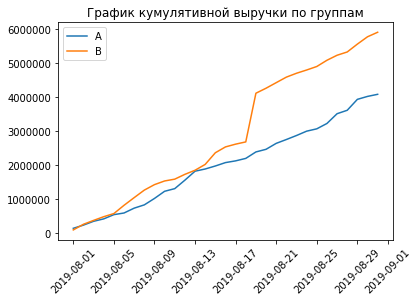

In [40]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'],  cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивной выручки по группам')
plt.legend()

Выручка равномерно росла в обеих группах. В группе В присутствует резкий скачок - возможен всплеск числа заказов, либо в выборке присутствуют очень дорогие заказы.

Построим графики среднего чека по группам

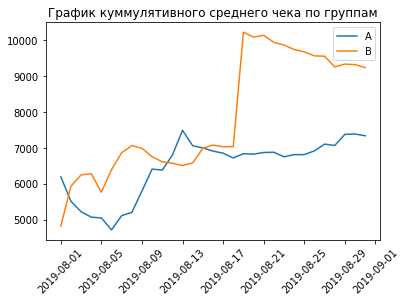

In [41]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.legend()

Средний чек для группы В имеет несколько скачков и к последней дате данных все ещё наблюдается спад среднего чека, возможно необзходимо больше данных, чтобы приблизится к реальному среднему чеку. Для группы А средний чек становится равномерным к концу теста: установиился для данной группы

Построим график относительного изменения  кумулятивного среднего чека группы В к А

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

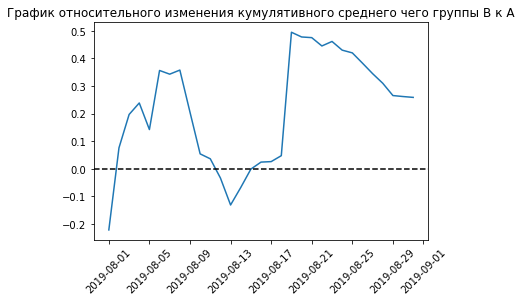

In [42]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чего группы В к А')
plt.xticks(rotation=45)

В начали много скачков на графике - присутстсвуют крупные заказы причем как в группе В так и в А



Построим график кумулятивной конверсии по группам

(array([737272., 737276., 737280., 737284., 737288., 737292., 737296.,
        737300., 737303.]),
 <a list of 9 Text xticklabel objects>)

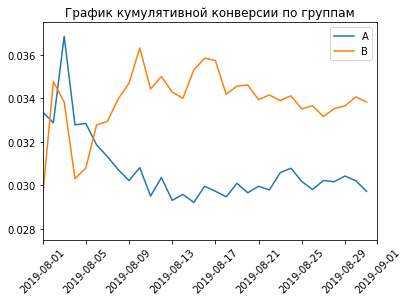

In [45]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам')
plt.legend()
plt.axis(["2019-08-01", '2019-09-01', 0.0275, 0.0375])
plt.xticks(rotation=45)


Конверсии для обеих групп зафиксировались к концу теста, группа А просела относительно группы В 

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

Text(0.5, 1.0, 'График относительного изменения кумулятивной конверсии группы В к А')

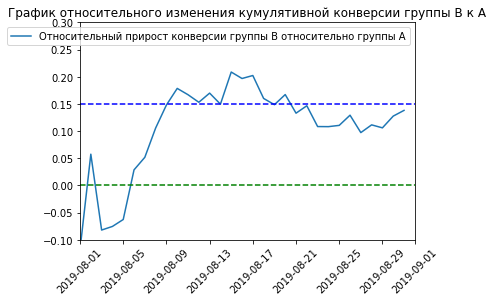

In [44]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()
plt.axhline(y=0, color='green', linestyle='--')
plt.axhline(y=0.15, color='blue', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.1, 0.3])
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивной конверсии группы В к А')

Конверсия в группе В в начале проседала относительно группы А, но со временем вырвалась в перед и установилась около прироста в 15%. В любом случае для начала необходимо провести анализ аномалий 



Построим точечный график распределения заказов по пользователям

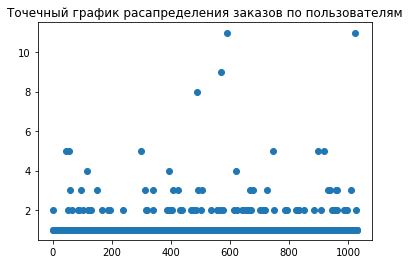

In [46]:
ordersByUsers = df_orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsers.columns = ['visitorId','orders']
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.title('Точечный график расапределения заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'])

Пользователей заказавших более 2 раз - мало. Возможно они аномальны, есть необходимость в проверке

Посчитаем 95-й и 99-й перцентили

In [24]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5 % пользователей совершали 2 заказа и не более 1% - больше 4. Границей поставим 2 заказа

Построим точечный график стоимостей заказов

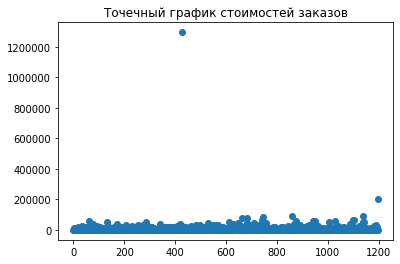

In [47]:
x_values = pd.Series(range(0,len(df_orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, df_orders['revenue'])

Имеем  аномальный выброс в стоимостях покупки, что подтверждает ранее предположение о наличии дорогих заказов



In [26]:
print(np.percentile(df_orders['revenue'], [95, 99]))

[28000.  58233.2]


Не более чем у 5 % заказов чек дороже 28000 рублей, и не более чем у 1% - выше 58233 рублей. Границей выбираем 28000 (Исправил в коде)



Посчитаем статистическую значимость различий в конверсии по данным с аномалиями ("сырым")

In [27]:
visitorsADaily = df_visitors[df_visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = df_visitors[df_visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [28]:
ordersADaily = df_orders[df_orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: \
        ordersADaily[ordersADaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateA' : 'sum',
                'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = df_orders[df_orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
    .groupby('date', as_index=False)\
    .agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: \
        ordersBDaily[ordersBDaily['date'] <= x['date']]\
            .agg({
                'date' : 'max',
                'ordersPerDateB' : 'sum',
                'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [29]:
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')


In [30]:
ordersByUsersA = df_orders[df_orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = df_orders[df_orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
print(" p-value = {0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print(" Относительный прирост {0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

 p-value = 0.00840
 Относительный прирост 0.138


В результате анализа сырых данных получили - что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13,8 %


Посчитаем статистическую значимость различий в чеке по группам по данным с аномалиями ("сырым")

In [31]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(df_orders[df_orders['group']=='A']['revenue'], df_orders[df_orders['group']=='B']['revenue'])[1]))
print("Относительная разница между группой В и А {0:.3f}".format(df_orders[df_orders['group']=='B']['revenue'].mean()/df_orders[df_orders['group']=='A']['revenue'].mean()-1))

p-value = 0.365
Относительная разница между группой В и А 0.259


p-value = 0.365. статистических различий в среднем чеке между группами нет , Относительное различие  среднего чека между сегментами около 26%

Очистим данные от аномалий и посчитаем теже метрики для "чистых данных"

In [32]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)
usersWithExpensiveOrders = df_orders[df_orders['revenue'] > 28000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

Посчитаем статистическую значимость конверсии

In [33]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("Статистическая значимость различия конверсий = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value = 0.007
Статистическая значимость различия конверсий = 0.173


Как и в случае с сырыми данными группа В лучше группы А

Посчитаем статистическую значимость чеков

In [34]:
print("p-value = {0:.3f}".format(stats.mannwhitneyu(
    df_orders[np.logical_and(
        df_orders['group']=='A',
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'],
    df_orders[np.logical_and(
        df_orders['group']=='B',
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

print("Статистическая значимость = {0:.3f}".format(
    df_orders[np.logical_and(df_orders['group']=='B',np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/
    df_orders[np.logical_and(
        df_orders['group']=='A',
        np.logical_not(df_orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))

p-value = 0.369
Статистическая значимость = -0.020


P-value  уменьшился по сравнению с сырыми данными0 а разница между сегментами координально изменилсь с превосходства сегмента В с 26% до превосходства сегмента А в 2 %



## Вывод  
Исходя из обнаруженных фактов, тест следует остановить и зафиксировать победу сегмента В. Сегмент В лучше сегмента А в конверсии покупателей, с незначительным проигрышем в среднем чеке.